# LogisticRegression-Graph

# Tutorial

In [213]:
"""
Reference:  Understanding Logistic Regression in Python 
            https://www.datacamp.com/tutorial/understanding-logistic-regression-python
"""

'\nReference:  Understanding Logistic Regression in Python \n            https://www.datacamp.com/tutorial/understanding-logistic-regression-python\n'

## Model building

### Loading data

In [214]:
#import pandas
import pandas as pd
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
# import the class - model
from sklearn.linear_model import LogisticRegression
# import the metrics class - confusion matrix
from sklearn import metrics
# import required modules - visualization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report


In [215]:
# #import pandas
# import pandas as pd

col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
# load dataset
pima = pd.read_csv("pima-indians-diabetes.csv", header=None, skiprows=1, names=col_names)
# First row contains:
# Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome

In [216]:
pima.head()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Selecting features

In [217]:
#split dataset in features and target variable
feature_cols = ['pregnant', 'insulin', 'bmi', 'age','glucose','bp','pedigree']
X = pima[feature_cols] # Features
y = pima.label # Target variable

### Splitting data

In [218]:
# # split X and y into training and testing sets
# from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=16)

### Model development and prediction

In [219]:
# # import the class
# from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16)

# fit the model with data
logreg.fit(X_train, y_train)

/home/fogo/miniconda3/envs/jupyterenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=16)

In [220]:
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:, 1]

In [221]:
# Save
# Add predictions to test dataset
normal_test_results = X_test.copy()
normal_test_results['true_label'] = y_test.values
normal_test_results['y_pred'] = y_pred

In [222]:
normal_test_results.head()

,pregnant,insulin,bmi,age,glucose,bp,pedigree,true_label,y_pred
515,3,105,31.6,28,163,70,0.268,1,1
462,8,49,35.3,39,74,70,0.705,0,0
55,1,0,23.0,21,73,50,0.248,0,0
684,5,0,0.0,69,136,82,0.640,0,0
383,1,59,25.1,25,90,62,1.268,0,0


In [223]:
normal_test_results.to_csv('diabetes_normal.csv', index=False)

## Trigger Drift

### Check feature importance

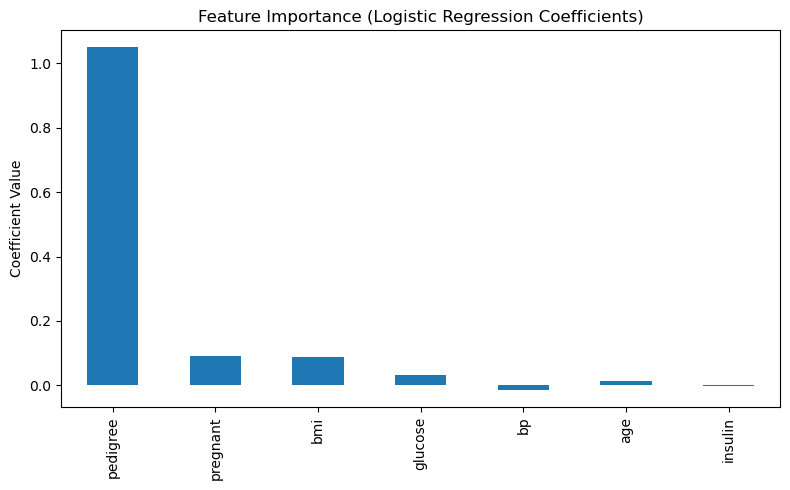

In [224]:
# Get feature importance from logistic regression coefficients
coefficients = pd.Series(logreg.coef_[0], index=X_train.columns)  # logreg.coef_ is a 2D array ([n_classes, n_features], binary [0] 
coefficients = coefficients.sort_values(key=abs, ascending=False)  # Sort by absolute importance

# Plot
plt.figure(figsize=(8, 5))
coefficients.plot(kind='bar', title='Feature Importance (Logistic Regression Coefficients)')
plt.ylabel('Coefficient Value')
plt.tight_layout()
plt.show()

In [225]:
print("Model Coefficients:\n", coefficients) # positive means you can increase to push 

Model Coefficients:
 pedigree    1.048738
pregnant    0.090012
bmi         0.087288
glucose     0.031571
bp         -0.013528
age         0.013251
insulin    -0.001317
dtype: float64


In [226]:
print(pima['pedigree'].describe())

count    768.000000
mean       0.471876
std        0.331329
min        0.078000
25%        0.243750
50%        0.372500
75%        0.626250
max        2.420000
Name: pedigree, dtype: float64


## input data quality

In [227]:
# Create a drifted test set by increasing the 'pedigree' feature
X_test_drifted_quality = X_test.copy()
# X_test_drifted['pedigree'] = X_test_drifted['pedigree'] * 1.5
X_test_drifted_quality['pedigree'] = -1 * X_test_drifted_quality['pedigree']


In [228]:
y_pred_drifted_quality = logreg.predict(X_test_drifted_quality)

In [229]:
# Save
# Add predictions to test dataset
quality_test_results = X_test_drifted_quality.copy()
quality_test_results['true_label'] = y_test.values
quality_test_results['y_pred'] = y_pred
quality_test_results['y_pred_drifted'] = y_pred_drifted_quality

quality_test_results.head()

,pregnant,insulin,bmi,age,glucose,bp,pedigree,true_label,y_pred,y_pred_drifted
515,3,105,31.6,28,163,70,-0.268,1,1,0
462,8,49,35.3,39,74,70,-0.705,0,0,0
55,1,0,23.0,21,73,50,-0.248,0,0,0
684,5,0,0.0,69,136,82,-0.640,0,0,0
383,1,59,25.1,25,90,62,-1.268,0,0,0


In [230]:
quality_test_results.to_csv('diabetes_quality_drift.csv', index=False)

In [231]:
from psi import calculate_psi

# y_pred = y_pred.map({False:0,True:1})
# y_pred_drift = y_pred_drift.map({False:0,True:1})
y_pred = np.vectorize({False: 0, True: 1}.get)(y_pred)
y_pred_drifted = np.vectorize({False: 0, True: 1}.get)(y_pred_drifted)


calculate_psi(y_pred, y_pred_drifted, buckets=2, axis=1)

np.float64(0.5800095593282056)

## input data drift

In [232]:
# Create a drifted test set by increasing the 'pedigree' feature
X_test_drifted = X_test.copy()
# X_test_drifted['pedigree'] = X_test_drifted['pedigree'] * 1.5
# X_test_drifted['pedigree'] = -1 * X_test_drifted['pedigree']

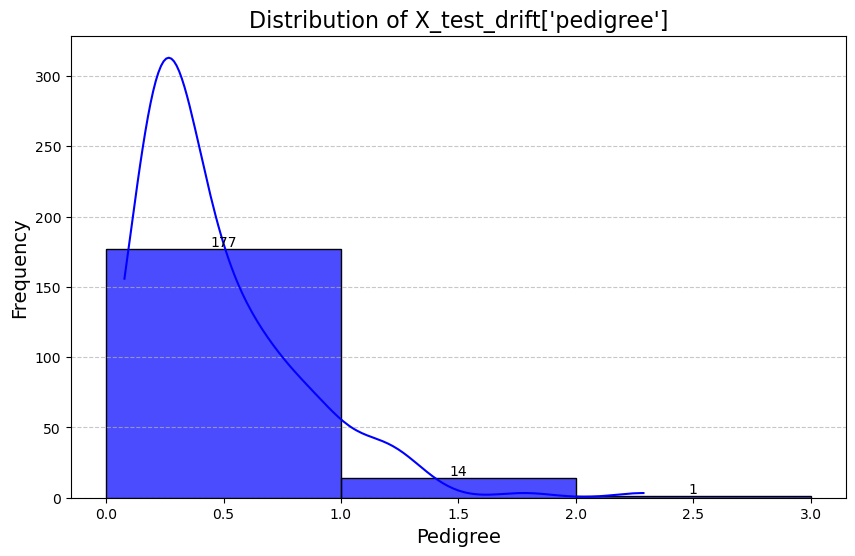

In [254]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Plot the distribution of 'pedigree'
# plt.figure(figsize=(10, 6))
# sns.histplot(X_test['pedigree'], bins=[0, 1, 2, 3], binrange=(0, 3), kde=True, color='blue', alpha=0.7)
# plt.title('Distribution of X_test[\'pedigree\']', fontsize=16)
# plt.xlabel('pedigree', fontsize=14)
# plt.ylabel('Frequency', fontsize=14)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()

import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of 'pedigree'
plt.figure(figsize=(10, 6))
ax = sns.histplot(X_test['pedigree'], kde=True, color='blue', alpha=0.7, bins=[0, 1, 2, 3], binrange=(0, 3))

# Annotate each bar with its height
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:  # Only annotate bars with a height greater than 0
        ax.annotate(f'{int(height)}', 
                    (patch.get_x() + patch.get_width() / 2, height), 
                    ha='center', va='bottom', fontsize=10, color='black')

plt.title('Distribution of X_test_drift[\'pedigree\']', fontsize=16)
plt.xlabel('Pedigree', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [234]:
max_value = X_test['pedigree'].max()
print(max_value)

2.288


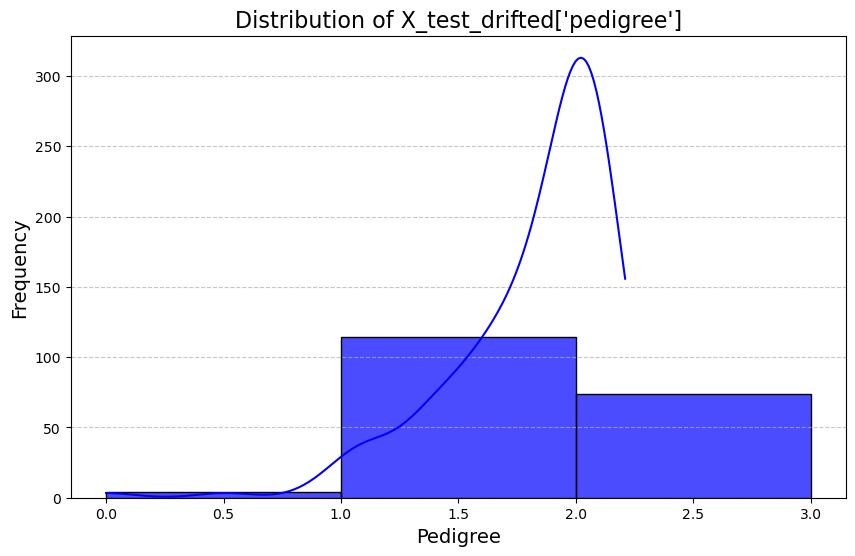

In [235]:
X_test_drifted['pedigree'] = max_value - X_test_drifted['pedigree']

# Display the mirrored column
plt.figure(figsize=(10, 6))
sns.histplot(X_test_drifted['pedigree'], bins=[0, 1, 2, 3], binrange=(0, 3), kde=True, color='blue', alpha=0.7)
plt.title('Distribution of X_test_drifted[\'pedigree\']', fontsize=16)
plt.xlabel('Pedigree', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [236]:
y_pred_drifted = logreg.predict(X_test_drifted)

In [237]:
# Save
# Add predictions to test dataset
data_test_results = X_test_drifted.copy()
data_test_results['true_label'] = y_test.values
data_test_results['y_pred'] = y_pred
data_test_results['y_pred_drifted'] = y_pred_drifted

data_test_results.head()

,pregnant,insulin,bmi,age,glucose,bp,pedigree,true_label,y_pred,y_pred_drifted
515,3,105,31.6,28,163,70,2.020,1,1,1
462,8,49,35.3,39,74,70,1.583,0,0,0
55,1,0,23.0,21,73,50,2.040,0,0,0
684,5,0,0.0,69,136,82,1.648,0,0,0
383,1,59,25.1,25,90,62,1.020,0,0,0


In [238]:
data_test_results.to_csv('diabetes_data_drift.csv', index=False)

In [239]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8177083333333334
Precision: 0.8076923076923077
Recall: 0.6268656716417911


In [240]:
accuracy = accuracy_score(y_test, y_pred_drifted)
precision = precision_score(y_test, y_pred_drifted)
recall = recall_score(y_test, y_pred_drifted)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.65625
Precision: 0.5040650406504065
Recall: 0.9253731343283582


In [241]:
y_pred = np.vectorize({False: 0, True: 1}.get)(y_pred)
y_pred_drifted = np.vectorize({False: 0, True: 1}.get)(y_pred_drifted)


calculate_psi(y_pred, y_pred_drifted, buckets=2, axis=1)

np.float64(0.5800095593282056)

In [242]:
calculate_psi(X_test['pedigree'], X_test_drifted['pedigree'], buckets=10, axis=1)

np.float64(11.16328916617941)

# Model drift graphs

In [243]:
import numpy as np
import pandas as pd
num_iterations = 200
sample_size = 50

# Store results for each iteration
X_results = []
y_results = []

df_X = pd.DataFrame(columns=X_test.columns)
arr_y = np.array([])

for i in range(1, num_iterations + 1):
    if i <= 100:
        # First 100 iterations: Choose from X_test and y_pred
        random_indices = np.random.choice(len(y_pred), size=sample_size, replace=False)
        X_sample = X_test.iloc[random_indices]
        y_sample = y_pred[random_indices]
        # print(type(X_sample))
        # print(type(y_sample))
    elif 101 <= i <= 110:
        # Iterations 101-110: Choose from X_test_drift and y_pred_drift
        random_indices = np.random.choice(len(y_pred_drifted), size=sample_size, replace=False)
        X_sample = X_test_drifted.iloc[random_indices]
        y_sample = y_pred_drifted[random_indices]
    else:
        # Iterations 111-200: Choose from X_test and y_pred
        random_indices = np.random.choice(len(y_pred), size=sample_size, replace=False)
        X_sample = X_test.iloc[random_indices]
        y_sample = y_pred[random_indices]

    df_X = pd.concat([df_X, X_sample], ignore_index=True)
    arr_y = np.append(arr_y, y_sample)


/tmp/ipykernel_668033/1001318116.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_X = pd.concat([df_X, X_sample], ignore_index=True)


In [244]:
len(df_X)
len(arr_y)

10000

In [245]:
window_size = 300
psi_values = []

results = arr_y
# Check if results array has enough data
if len(results) < window_size:
    print("Not enough data in results for sliding window.")
else:
    # Sliding window loop
    for start in range(len(results) - window_size + 1):
        # Get the current window
        window = results[start:start + window_size]
        
        # Extract expected and actual values
        expected = window[:window_size // 2]  # First half of the window
        actual = window[window_size // 2:]   # Second half of the window
        
        # Debugging: Check sizes
        # print(f"Processing window starting at index {start}")
        # print(f"Expected size: {len(expected)}, Actual size: {len(actual)}")
        
        # Calculate PSI for the current window
        psi_value = calculate_psi(expected, actual, buckets=2, axis=0)
        psi_values.append(psi_value)

# Print or process the PSI values
# print("PSI values for sliding windows:", psi_values)

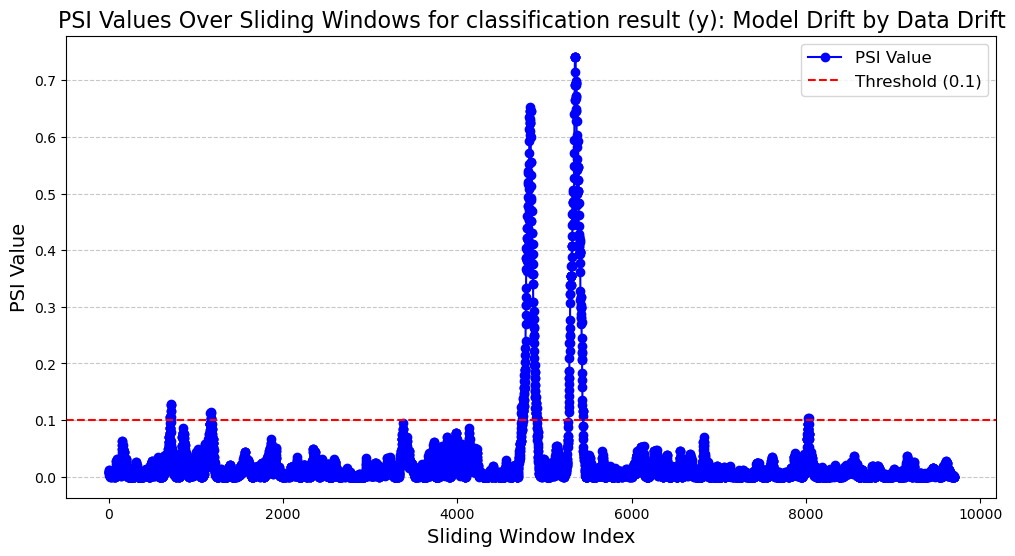

In [246]:
import matplotlib.pyplot as plt

# Assuming psi_values is already calculated
plt.figure(figsize=(12, 6))
plt.plot(range(len(psi_values)), psi_values, marker='o', linestyle='-', color='b', label='PSI Value')
plt.title('PSI Values Over Sliding Windows for classification result (y): Model Drift by Data Drift', fontsize=16)
plt.xlabel('Sliding Window Index', fontsize=14)
plt.ylabel('PSI Value', fontsize=14)
plt.axhline(y=0.1, color='r', linestyle='--', label='Threshold (0.1)')
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [247]:
window_size = 300
psi_values = []

results = df_X['pedigree']
# Check if results array has enough data
if len(results) < window_size:
    print("Not enough data in results for sliding window.")
else:
    # Sliding window loop
    for start in range(len(results) - window_size + 1):
        # Get the current window
        window = results[start:start + window_size]
        
        # Extract expected and actual values
        expected = window[:window_size // 2]  # First half of the window
        actual = window[window_size // 2:]   # Second half of the window
        
        # Debugging: Check sizes
        # print(f"Processing window starting at index {start}")
        # print(f"Expected size: {len(expected)}, Actual size: {len(actual)}")
        
        # Calculate PSI for the current window
        psi_value = calculate_psi(expected, actual, buckets=3, axis=0)
        psi_values.append(psi_value)

# Print or process the PSI values
# print("PSI values for sliding windows:", psi_values)

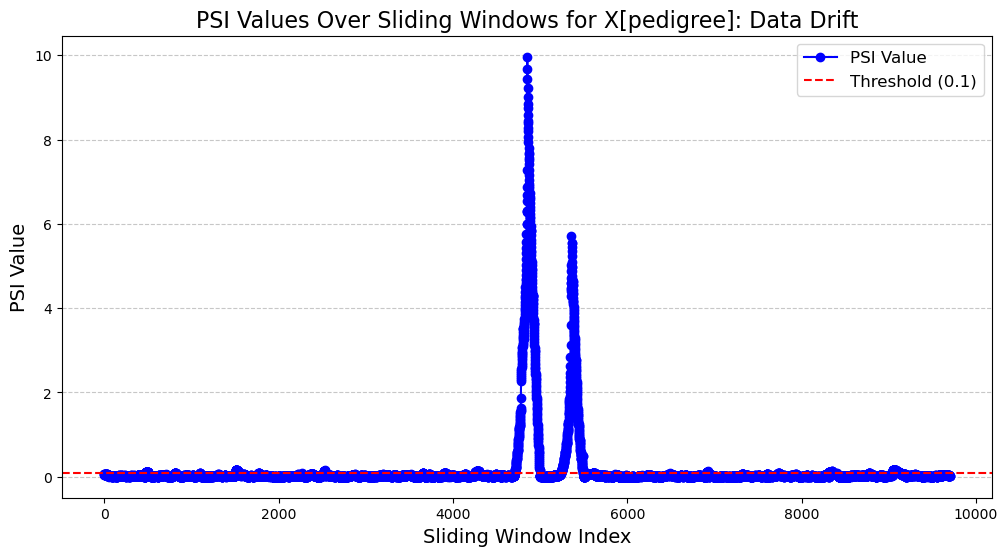

In [248]:
import matplotlib.pyplot as plt

# Assuming psi_values is already calculated
plt.figure(figsize=(12, 6))
plt.plot(range(len(psi_values)), psi_values, marker='o', linestyle='-', color='b', label='PSI Value')
plt.title('PSI Values Over Sliding Windows for X[pedigree]: Data Drift', fontsize=16)
plt.xlabel('Sliding Window Index', fontsize=14)
plt.ylabel('PSI Value', fontsize=14)
plt.axhline(y=0.1, color='r', linestyle='--', label='Threshold (0.1)')
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Data quality

In [249]:
import numpy as np
import pandas as pd
num_iterations = 200
sample_size = 50

# Store results for each iteration
X_results = []
y_results = []

df_X = pd.DataFrame(columns=X_test.columns)
arr_y = np.array([])

for i in range(1, num_iterations + 1):
    if i <= 100:
        # First 100 iterations: Choose from X_test and y_pred
        random_indices = np.random.choice(len(y_pred), size=sample_size, replace=False)
        X_sample = X_test.iloc[random_indices]
        y_sample = y_pred[random_indices]
        # print(type(X_sample))
        # print(type(y_sample))
    elif 101 <= i <= 110:
        # Iterations 101-110: Choose from X_test_drift and y_pred_drift
        random_indices = np.random.choice(len(y_pred_drifted), size=sample_size, replace=False)
        X_sample = X_test_drifted_quality.iloc[random_indices]
        y_sample = y_pred_drifted_quality[random_indices]
    else:
        # Iterations 111-200: Choose from X_test and y_pred
        random_indices = np.random.choice(len(y_pred), size=sample_size, replace=False)
        X_sample = X_test.iloc[random_indices]
        y_sample = y_pred[random_indices]

    df_X = pd.concat([df_X, X_sample], ignore_index=True)
    arr_y = np.append(arr_y, y_sample)


/tmp/ipykernel_668033/1922037438.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_X = pd.concat([df_X, X_sample], ignore_index=True)


In [250]:
len(df_X)
len(arr_y)

10000

In [251]:
window_size = 300
psi_values = []

results = arr_y
# Check if results array has enough data
if len(results) < window_size:
    print("Not enough data in results for sliding window.")
else:
    # Sliding window loop
    for start in range(len(results) - window_size + 1):
        # Get the current window
        window = results[start:start + window_size]
        
        # Extract expected and actual values
        expected = window[:window_size // 2]  # First half of the window
        actual = window[window_size // 2:]   # Second half of the window
        
        # Debugging: Check sizes
        # print(f"Processing window starting at index {start}")
        # print(f"Expected size: {len(expected)}, Actual size: {len(actual)}")
        
        # Calculate PSI for the current window
        psi_value = calculate_psi(expected, actual, buckets=2, axis=0)
        psi_values.append(psi_value)

# Print or process the PSI values
# print("PSI values for sliding windows:", psi_values)

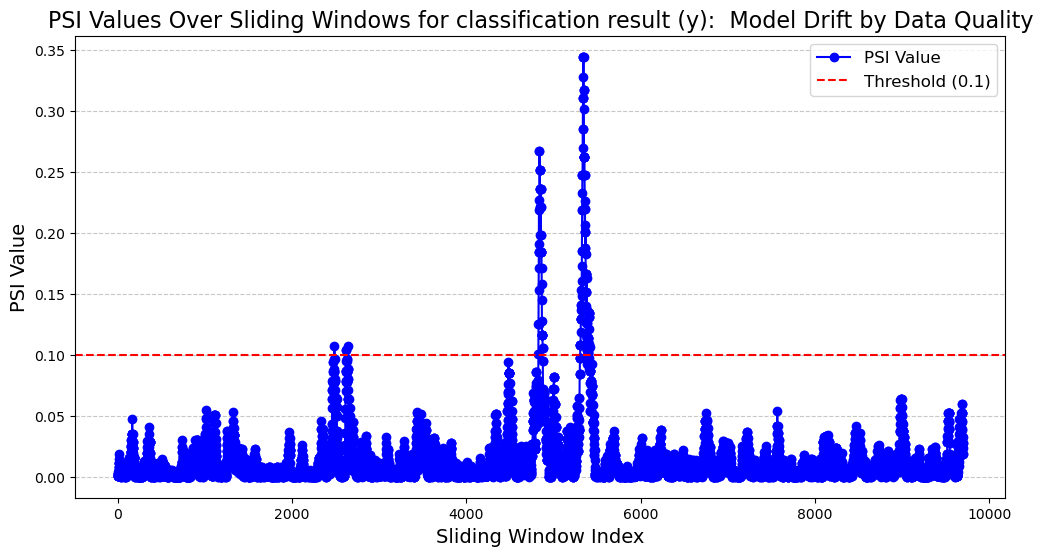

In [252]:
import matplotlib.pyplot as plt

# Assuming psi_values is already calculated
plt.figure(figsize=(12, 6))
plt.plot(range(len(psi_values)), psi_values, marker='o', linestyle='-', color='b', label='PSI Value')
plt.title('PSI Values Over Sliding Windows for classification result (y):  Model Drift by Data Quality', fontsize=16)
plt.xlabel('Sliding Window Index', fontsize=14)
plt.ylabel('PSI Value', fontsize=14)
plt.axhline(y=0.1, color='r', linestyle='--', label='Threshold (0.1)')
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()